## 1. Initial Setup

### 1.1 Imports

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import scipy.constants as sc

import sys
sys.path.append('../python')
import AlasBabylon

import matplotlib.pyplot as plt

%matplotlib inline


### 1.2 Pseudo-hexadecimal translations

In [2]:
# Python dictionaries to help in translating between
#  spec ID entries ("s" numbers) and S. Shectman's
#  pseudo-hex notation.

apernum_to_ShectHex_dict = \
{
    '1':'01',   '15':'11',   '29':'21',   '43':'31',
    '2':'02',   '16':'12',   '30':'22',   '44':'32',
    '3':'03',   '17':'13',   '31':'23',   '45':'33',
    '4':'04',   '18':'14',   '32':'24',   '46':'34',
    '5':'05',   '19':'15',   '33':'25',   '47':'35',
    '6':'06',   '20':'16',   '34':'26',   '48':'36',
    '7':'07',   '21':'17',   '35':'27',   '49':'37',
    '8':'08',   '22':'18',   '36':'28',   '50':'38',
    '9':'09',   '23':'19',   '37':'29',   '51':'39',
    '10':'0A',   '24':'1A',   '38':'2A',   '52':'3A',
    '11':'0B',   '25':'1B',   '39':'2B',   '53':'3B',
    '12':'0C',   '26':'1C',   '40':'2C',   '54':'3C',
    '13':'0D',   '27':'1D',   '41':'2D',   '55':'3D',
    '14':'0E',   '28':'1E',   '42':'2E',   '56':'3E',
    '57':'41',   '71':'51',   '85':'61',   '99':'71',
    '58':'42',   '72':'52',   '86':'62',   '100':'72',
    '59':'43',   '73':'53',   '87':'63',   '101':'73',
    '60':'44',   '74':'54',   '88':'64',   '102':'74',
    '61':'45',   '75':'55',   '89':'65',   '103':'75',
    '62':'46',   '76':'56',   '90':'66',   '104':'76',
    '63':'47',   '77':'57',   '91':'67',   '105':'77',
    '64':'48',   '78':'58',   '92':'68',   '106':'78',
    '65':'49',   '79':'59',   '93':'69',   '107':'79',
    '66':'4A',   '80':'5A',   '94':'6A',   '108':'7A',
    '67':'4B',   '81':'5B',   '95':'6B',   '109':'7B',
    '68':'4C',   '82':'5C',   '96':'6C',   '110':'7C',
    '69':'4D',   '83':'5D',   '97':'6D',   '111':'7D',
    '70':'4E',   '84':'5E',   '98':'6E',   '112':'7E',
    
}


shectHex_to_apernum_dict = \
{
    '01':'1',   '11':'15',   '21':'29',   '31':'43',
    '02':'2',   '12':'16',   '22':'30',   '32':'44',
    '03':'3',   '13':'17',   '23':'31',   '33':'45',
    '04':'4',   '14':'18',   '24':'32',   '34':'46',
    '05':'5',   '15':'19',   '25':'33',   '35':'47',
    '06':'6',   '16':'20',   '26':'34',   '36':'48',
    '07':'7',   '17':'21',   '27':'35',   '37':'49',
    '08':'8',   '18':'22',   '28':'36',   '38':'50',
    '09':'9',   '19':'23',   '29':'37',   '39':'51',
    '0A':'10',   '1A':'24',   '2A':'38',   '3A':'52',
    '0B':'11',   '1B':'25',   '2B':'39',   '3B':'53',
    '0C':'12',   '1C':'26',   '2C':'40',   '3C':'54',
    '0D':'13',   '1D':'27',   '2D':'41',   '3D':'55',
    '0E':'14',   '1E':'28',   '2E':'42',   '3E':'56',
    '41':'57',   '51':'71',   '61':'85',   '71':'99',
    '42':'58',   '52':'72',   '62':'86',   '72':'100',
    '43':'59',   '53':'73',   '63':'87',   '73':'101',
    '44':'60',   '54':'74',   '64':'88',   '74':'102',
    '45':'61',   '55':'75',   '65':'89',   '75':'103',
    '46':'62',   '56':'76',   '66':'90',   '76':'104',
    '47':'63',   '57':'77',   '67':'91',   '77':'105',
    '48':'64',   '58':'78',   '68':'92',   '78':'106',
    '49':'65',   '59':'79',   '69':'93',   '79':'107',
    '4A':'66',   '5A':'80',   '6A':'94',   '7A':'108',
    '4B':'67',   '5B':'81',   '6B':'95',   '7B':'109',
    '4C':'68',   '5C':'82',   '6C':'96',   '7C':'110',
    '4D':'69',   '5D':'83',   '6D':'97',   '7D':'111',
    '4E':'70',   '5E':'84',   '6E':'98',   '7E':'112'
}

### 1.3 Standard paths

In [3]:
lcrs_cat_dirname = '../data/cats'

lcrs_cat_cat_filename = 'Vizier_LCRS_1996_VII_203_catalog.csv'
lcrs_cat_flds_filename = 'Vizier_LCRS_1996_VII_203_fields.csv'

lcrs_cat_cat_fullfilename = os.path.join(lcrs_cat_dirname, lcrs_cat_cat_filename)
lcrs_cat_flds_fullfilename = os.path.join(lcrs_cat_dirname, lcrs_cat_flds_filename)

lcrs_spectra_dirname = '../data/spectraFITS'

## 2. User input

In [4]:
# LCRS spectrum to identify and plot...
lcrs_objname = 'LCRS B013916.9-445123'

# Directory to which to send output (plots, CSV files, etc.)...
output_dirname = '~'

## 3. Identify Object in LCRS Catalog

In [5]:
# Read lcrs_cat_cat_fullfilenameCSV file into Pandas dataframe...
df_lcrscat = pd.read_csv(lcrs_cat_cat_fullfilename)
df_lcrscat.head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,cz,e_cz,sf,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs
0,1,0000-42E,496.0,17.52,0000-4225,18.36,00 08 30.09,-42 25 55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000830.0-422555,Simbad,00 11 01.27,-42 09 13.9
1,2,0000-42E,583.0,18.02,0000-4212,18.46,00 08 31.98,-42 12 22.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000831.9-421222,Simbad,00 11 03.17,-41 55 41.3
2,3,0000-42E,514.0,17.92,0000-4237,18.27,00 08 33.01,-42 33 45.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.0-423345,Simbad,00 11 04.16,-42 17 04.1
3,4,0000-42E,512.2,15.70,0000-4147,14.16,00 08 33.20,-41 48 53.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.2-414853,Simbad,00 11 04.42,-41 32 11.7
4,5,0000-42E,501.0,17.51,0000-4225,18.30,00 08 33.45,-42 29 20.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.4-422920,Simbad,00 11 04.61,-42 12 39.3


In [6]:
# Let's also create raDeg1950, decDeg1950 columns based on the RA1950, DE1950 columns...
df_lcrscat['raHMS1950'] = df_lcrscat['RA1950'].str.replace(' ', ':')
df_lcrscat['decDMS1950'] = df_lcrscat['DE1950'].str.replace(' ', ':')
df_lcrscat['raDeg1950'] = df_lcrscat['raHMS1950'].apply(AlasBabylon.HMSToDeg)
df_lcrscat['decDeg1950'] = df_lcrscat['decDMS1950'].apply(AlasBabylon.DMSToDeg)
df_lcrscat.head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,...,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs,raHMS1950,decDMS1950,raDeg1950,decDeg1950
0,1,0000-42E,496.0,17.52,0000-4225,18.36,00 08 30.09,-42 25 55.5,NaN,NaN,...,NaN,NaN,B000830.0-422555,Simbad,00 11 01.27,-42 09 13.9,00:08:30.09,-42:25:55.5,2.125375,-42.432083
1,2,0000-42E,583.0,18.02,0000-4212,18.46,00 08 31.98,-42 12 22.9,NaN,NaN,...,NaN,NaN,B000831.9-421222,Simbad,00 11 03.17,-41 55 41.3,00:08:31.98,-42:12:22.9,2.133250,-42.206361
2,3,0000-42E,514.0,17.92,0000-4237,18.27,00 08 33.01,-42 33 45.7,NaN,NaN,...,NaN,NaN,B000833.0-423345,Simbad,00 11 04.16,-42 17 04.1,00:08:33.01,-42:33:45.7,2.137542,-42.562694
3,4,0000-42E,512.2,15.70,0000-4147,14.16,00 08 33.20,-41 48 53.3,NaN,NaN,...,NaN,NaN,B000833.2-414853,Simbad,00 11 04.42,-41 32 11.7,00:08:33.20,-41:48:53.3,2.138333,-41.814806
4,5,0000-42E,501.0,17.51,0000-4225,18.30,00 08 33.45,-42 29 20.9,NaN,NaN,...,NaN,NaN,B000833.4-422920,Simbad,00 11 04.61,-42 12 39.3,00:08:33.45,-42:29:20.9,2.139375,-42.489139


In [7]:
# Let's create a mask that only includes LCRS objects with a measured LCRS redshift:
mask_redshift = ~df_lcrscat['cz'].isnull()
df_lcrscat[mask_redshift].head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,...,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs,raHMS1950,decDMS1950,raDeg1950,decDeg1950
17,18,0000-42E,631.0,16.48,0000-4122,17.33,00 08 48.00,-41 28 04.6,646,c,...,0.232,NaN,B000848.0-412804,Simbad,00 11 19.19,-41 11 23.1,00:08:48.00,-41:28:04.6,2.200000,-41.467944
18,19,0000-42E,536.0,16.91,0000-4237,17.60,00 08 49.25,-42 33 31.7,637,c,...,0.348,NaN,B000849.2-423331,Simbad,00 11 20.33,-42 16 50.2,00:08:49.25,-42:33:31.7,2.205208,-42.558806
19,20,0000-42E,519.0,16.81,0000-4225,17.68,00 08 49.48,-42 26 10.0,638,c,...,0.298,NaN,B000849.4-422610,Simbad,00 11 20.57,-42 09 28.5,00:08:49.48,-42:26:10.0,2.206167,-42.436111
31,32,0000-42E,552.0,17.03,0000-4237,17.72,00 09 01.26,-42 33 17.3,636,c,...,0.348,NaN,B000901.2-423317,Simbad,00 11 32.29,-42 16 35.8,00:09:01.26,-42:33:17.3,2.255250,-42.554806
33,34,0000-42E,533.0,16.89,0000-4225,17.77,00 09 01.80,-42 20 10.0,639,c,...,0.333,NaN,B000901.8-422010,Simbad,00 11 32.85,-42 03 28.5,00:09:01.80,-42:20:10.0,2.257500,-42.336111


In [8]:
# Read lcrs_cat_flds_fullfilename CSV file into Pandas dataframe...
df_lcrsflds = pd.read_csv(lcrs_cat_flds_fullfilename)
df_lcrsflds.head(5)

,recno,Field,RA1,RA2,DE1,DE2,m1,m2,mcen,Nfib,Ngal,f,Night,Frame,plate,_RA.icrs,_DE.icrs
0,1,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 08 28.66,00 15 43.22,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,37,0.31,1989-03-10,163,SSA007-600; 0000-42E,00 10 59.82,-42 27 23.0
1,2,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 01 25.73,00 08 28.66,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,40,0.35,1989-02-10,149,SSA010-200; 0000-42W,00 03 58.77,-42 27 22.2
2,3,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 33 03.82,00 41 21.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,81,0.88,1993-03-10,192,SSA064-200; 0015-42E,00 35 28.43,-42 27 42.6
3,4,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 23 41.14,00 33 03.82,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,107,0.85,1994-02-10,178,SSA063-200; 0015-42M,00 26 08.24,-42 27 37.3
4,5,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 15 43.22,00 23 41.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,105,0.56,1994-01-10,164,SSA062-200; 0015-42W,00 18 12.44,-42 27 34.1


In [9]:
# Let's also create raDeg1950, decDeg1950 columns based on the RA1950, DE1950 columns...
df_lcrsflds['raHMS1950_1'] = df_lcrsflds['RA1'].str.replace(' ', ':')
df_lcrsflds['raHMS1950_2'] = df_lcrsflds['RA2'].str.replace(' ', ':')
df_lcrsflds['decDMS1950_1'] = df_lcrsflds['DE1'].str.replace(' ', ':')
df_lcrsflds['decDMS1950_2'] = df_lcrsflds['DE2'].str.replace(' ', ':')
df_lcrsflds['raDeg1950_1'] = df_lcrsflds['raHMS1950_1'].apply(AlasBabylon.HMSToDeg)
df_lcrsflds['raDeg1950_2'] = df_lcrsflds['raHMS1950_2'].apply(AlasBabylon.HMSToDeg)
df_lcrsflds['decDeg1950_1'] = df_lcrsflds['decDMS1950_1'].apply(AlasBabylon.DMSToDeg)
df_lcrsflds['decDeg1950_2'] = df_lcrsflds['decDMS1950_2'].apply(AlasBabylon.DMSToDeg)
df_lcrsflds.head(5)

,recno,Field,RA1,RA2,DE1,DE2,m1,m2,mcen,Nfib,...,_RA.icrs,_DE.icrs,raHMS1950_1,raHMS1950_2,decDMS1950_1,decDMS1950_2,raDeg1950_1,raDeg1950_2,decDeg1950_1,decDeg1950_2
0,1,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 08 28.66,00 15 43.22,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,...,00 10 59.82,-42 27 23.0,00:08:28.66,00:15:43.22,-42:44:04.6,-41:15:28.8,2.119417,3.930083,-42.734611,-41.258000
1,2,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 01 25.73,00 08 28.66,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,...,00 03 58.77,-42 27 22.2,00:01:25.73,00:08:28.66,-42:44:04.6,-41:15:28.8,0.357208,2.119417,-42.734611,-41.258000
2,3,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 33 03.82,00 41 21.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 35 28.43,-42 27 42.6,00:33:03.82,00:41:21.14,-42:44:13.9,-41:14:42.7,8.265917,10.338083,-42.737194,-41.245194
3,4,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 23 41.14,00 33 03.82,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 26 08.24,-42 27 37.3,00:23:41.14,00:33:03.82,-42:44:13.9,-41:14:42.7,5.921417,8.265917,-42.737194,-41.245194
4,5,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 15 43.22,00 23 41.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 18 12.44,-42 27 34.1,00:15:43.22,00:23:41.14,-42:44:13.9,-41:14:42.7,3.930083,5.921417,-42.737194,-41.245194


In [10]:
# Identify LCRS object of interest:
lcrs_objname_trunc =  lcrs_objname.split()[1]
df_lcrscat_obj = df_lcrscat[(df_lcrscat.LCRS == lcrs_objname_trunc)]

n_match = len(df_lcrscat_obj)

if n_match == 0:
    text = """No matches found for %s...""" % (lcrs_objname)
    print(text)
elif n_match == 1:
    text = """Single match found for %s...""" % (lcrs_objname)
    print(text)
elif n_match > 1:
    text = """Multiple matches found for %s...  Chosing first in list""" % (lcrs_objname)
    print(text)

lcrscat_obj_info = df_lcrscat_obj.iloc[0]

text = """Here is the info from %s for %s:""" % (lcrs_cat_cat_fullfilename, lcrs_objname)
print(text)
print(lcrscat_obj_info)

Single match found for LCRS B013916.9-445123...
Here is the info from ../data/cats/Vizier_LCRS_1996_VII_203_catalog.csv for LCRS B013916.9-445123:
recno                     8628
Field                 0115-45E
p                       1740.0
mag                       16.6
Scan                 0115-4447
mc                       17.74
RA1950             01 39 16.94
DE1950             -44 51 23.3
s                          315
type                         b
cz                     28354.0
e_cz                      35.0
sf                        0.77
gsf                      0.691
cz55                       NaN
LCRS          B013916.9-445123
Simbad                  Simbad
_RA.icrs           01 41 22.63
_DE.icrs           -44 36 15.3
raHMS1950          01:39:16.94
decDMS1950         -44:51:23.3
raDeg1950            24.820583
decDeg1950          -44.856472
Name: 8627, dtype: object


In [11]:
# ... and extract the RA, DEC, redshift, spectro field, spectro ID, and 
#     spectra type ([c]ontinuum, [e]mission, etc.)
raHMS1950 = lcrscat_obj_info.RA1950
decDMS1950 = lcrscat_obj_info.DE1950
raDeg1950 = lcrscat_obj_info.raDeg1950
decDeg1950 = lcrscat_obj_info.decDeg1950
cz = lcrscat_obj_info.cz
z = cz / (sc.c/1000.)
specfield = lcrscat_obj_info.Field   
spectype = lcrscat_obj_info.type
specID = lcrscat_obj_info.s        # Check this...
print(raHMS1950, decDMS1950, raDeg1950, decDeg1950, specfield, specID, cz, z, spectype)
#print(raHMS1950, decDMS1950, specfield, specID, cz, z, spectype)

01 39 16.94 -44 51 23.3 24.820583333333335 -44.85647222222222 0115-45E 315 28354.0 0.09457876355248404 b


In [12]:
# This will fail for fields that straddle RA=360deg/0deg,
#  but this will do for now...
mask_field = ( (raDeg1950 >= df_lcrsflds.raDeg1950_1) & \
               (raDeg1950 <= df_lcrsflds.raDeg1950_2) & \
               (decDeg1950 >= df_lcrsflds.decDeg1950_1) & \
               (decDeg1950 <= df_lcrsflds.decDeg1950_2) ) 

In [13]:
# Now let's look at fields are returned by this mask...
df_lcrsflds[mask_field]

,recno,Field,RA1,RA2,DE1,DE2,m1,m2,mcen,Nfib,...,_RA.icrs,_DE.icrs,raHMS1950_1,raHMS1950_2,decDMS1950_1,decDMS1950_2,raDeg1950_1,raDeg1950_2,decDeg1950_1,decDeg1950_2
27,28,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,01 33 38.40,01 42 04.80,-45 43 48.0,-44 15 00.0,14.94,17.64,18.94,112,...,01 35 44.75,-45 28 29.8,01:33:38.40,01:42:04.80,-45:43:48.0,-44:15:00.0,23.41,25.52,-45.73,-44.25


In [14]:
# Ah, fortunately, again there is only one entry returned!
df_lcrsflds[mask_field].iloc[0]

recno                                                          28
Field           http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...
RA1                                                   01 33 38.40
RA2                                                   01 42 04.80
DE1                                                   -45 43 48.0
DE2                                                   -44 15 00.0
m1                                                          14.94
m2                                                          17.64
mcen                                                        18.94
Nfib                                                          112
Ngal                                                           99
f                                                            0.79
Night                                                  1993-11-10
Frame                                                         139
plate                                        SSA060-300; 0115-45E
_RA.icrs  

In [15]:
# OK, we want to find plate "SSA029-400; 0354-39M" and/or Frame 169 from night 1991-07-10.

# The spectra files are ordered by Run data "YYMM" and possibly frame number ("g???.fits")
#  in the lcrs_spectra_dirname directory.  

# Let's loop through these g???.fits files, grabbing the values of DATE-OBS and OBJECT 
#  from the FITS header of each...


#lcrsSpecFileList = glob.glob('/usrdevel/dp0.b/users/dtucker/LCRSspectra/????/g*.fits')
globSearchString = os.path.join(lcrs_spectra_dirname, '????/g*.fits')
print(globSearchString)

lcrsSpecFileList = glob.glob(globSearchString)

for lcrsSpecFile in lcrsSpecFileList:

    trimmed_filename = os.path.basename(os.path.dirname(lcrsSpecFile))+"/"+os.path.basename(lcrsSpecFile)
    print(trimmed_filename, end='')
    
    hdulist = fits.open(lcrsSpecFile)
    hdr = hdulist[0].header
    
    print(" "+hdr['DATE-OBS']+"    "+hdr['OBJECT'])
    
    hdulist.close()


../data/spectraFITS/????/g*.fits
8910/g102.fits 29-09-89    SSA007-100; 2140-39W
8910/g177.fits 04-10-89    SSA008-600; 0220-39E
8910/g132.fits 01-10-89    SSA009-100; 2220-39E
8910/g169.fits 02-10-89    SSA007-800; 0320-42W
8910/g163.fits 02-10-89    SSA007-600; 0000-42E
8910/g180.fits 04-10-89    SSA008-700; 0320-42E
8910/g149.fits 02-10-89    SSA010-200; 0000-42W
8910/g121.fits 30-09-89    SSA008-200; 2300-39W
8910/g105.fits 29-09-89    SSA007-200; 0020-39W
8910/g174.fits 04-10-89    SSA008-500; 2340-39W
8910/g185.fits 06-10-89    SSA010-500; 0200-42E
8910/g152.fits 02-10-89    SSA010-300; 0100-39E
8910/g135.fits 01-10-89    SSA009-200; 2300-39E
8910/g155.fits 02-10-89    SSA010-400; 0240-42E
8910/g111.fits 29-09-89    SSA007-400; 0340-39W
8910/g141.fits 01-10-89    SSA009-400; 0240-42W
8910/g146.fits 02-10-89    SSA010-100; APM1W
8910/g108.fits 29-09-89    SSA007-300; 0020-39E
8910/g124.fits 30-09-89    SSA008-300; 0300-39E
8910/g166.fits 02-10-89    SSA007-700; 0220-39W
8910/g138.

In [16]:
# Hmmm...  According to the table in lcrs_cat_flds_filename, the spectra for LCRS B040659.9-385922
# is on plate 'SSA029-400; 0354-39M', which is also known as Frame 169, taken on the night of 
# 1991-07-10.

# Nothing seems to quite match.

# We have a plate 'SSA029-400; 0354-39M', but it is in 9110/g174.fits observed on DATE-OBS 08-10-91.

# We also have a file 9110/g169.fits observed on DATE-OBS 07-10-91, but that is suppposedly for 
#  plate 'SSA029-300; 0234-39W'.

# Of course, the date of 1991-07-10 may be for the civil date at the beginning of the night, with
#  08-10-91 being the UT date for that same civil date.  Still, if the 3-digit number in the FITS
#  file name is supposed to be the frame number, that would still be a discrepancy.



In [17]:
# Let's try 'SSA029-400; 0354-39M', but it is in 9110/g174.fits observed on DATE-OBS 08-10-91 as the 
#  more likely.

# No, in an e-mail from 31 August 2021, Huan found that the object is indeed in 9110/g169.fits.
# Also, don't forget:  IRAF is 1-indexed and python is 0-indexed; so we will want to grab line
#  "apernum-1" from the python array returned from the FITS file, where apernum is the aperture
#  number in the FITS file.

#lcrsSpecFile = '/usrdevel/dp0.b/users/dtucker/LCRSspectra/9110/g174.fits'
#lcrsSpecFile = '../data/spectraFITS/9110/g169.fits'
lcrsSpecFile = '../data/spectraFITS/9310/g139.fits'

In [18]:
# First open the file and read in the header and data...
hdulist = fits.open(lcrsSpecFile)
hdr = hdulist[0].header
data = hdulist[0].data
hdulist.close()

In [19]:
# Let's look at the header...
#  It looks like all the spectra for this plate are in this file.
#  It also looks like the spectra saved here all start at 3350 angstroms
#  and have 1361 bins with a bin-width of 2.5 angstroms.
hdr

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                  -32  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                 1361  /                                               
NAXIS2  =                  128  /                                               
OBJECT  = 'SSA060-300; 0115-45E            '  /                                 
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '15-02-94'            /                                               
IRAFNAME= 'g139.imh'            /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000E0  /  DATA MIN                                     
IRAF-BPX=                   32  /  DATA BITS/PIXEL                              
IRAFTYPE= 'REAL    '        

In [20]:
# Let's look at the data...
#  It looks like it is a 2D array of 128 spectra (presumably containing
#  calibration fibers along with the 112 LCRS targets).  As suspected 
#  from the header, each spectrum has 1361 fluxes associated with it.
print(data.shape)
data

(128, 1361)


array([[16.522785  , 18.310083  , 15.67852   , ...,  5.2354083 ,
         5.3449593 ,  3.3421953 ],
       [38.631554  , 35.12565   , 36.559994  , ...,  6.2708626 ,
         5.519262  ,  4.8617253 ],
       [ 5.9258795 ,  5.8350987 ,  6.3484025 , ...,  3.2562463 ,
         9.221746  ,  7.940566  ],
       ...,
       [-1.3047407 , -1.3870816 , -1.0988882 , ..., -2.478949  ,
        -1.2838763 , -1.4329842 ],
       [ 0.4155329 , -1.5288908 , -1.7507904 , ...,  0.22176053,
         0.27884224,  0.16513675],
       [ 3.4817796 ,  2.1916378 ,  1.3588145 , ...,  0.34523144,
         1.4821655 ,  0.89310974]], dtype=float32)

In [21]:
# The object we are looking for has a spectID=425.
# Folloing Huan Lin's instructions from 
# /usrdevel/dp0.b/users/dtucker/LCRSspectra/README,
# we should treat the '25' from the spectID as 
# a Shectman pseudo-hex number and use the table
# Huan provided in the README file to convert
# to the aperture number in the lcrsSpecFile.

#apernum = int(shectHex_to_apernum_dict['25'])
#print(apernum)

apernum = int(shectHex_to_apernum_dict['15'])
print(apernum)


19


In [22]:
# OK, let's grab the fluxes from this apernum.
#  We will use the values from the header to
#  generate the wavelengths associated with 
#  these fluxes.  Finally, we will combine 
#  the wavelength array with the flux array
#  to create a pandas DataFrame with these
#  data...

flux = data[(apernum-1),:]
wave_min = 3350.
wave_bin = 2.5 # Angstroms
wave_max = wave_min + wave_bin*len(flux)
wave = np.arange(wave_min,wave_max,wave_bin)
df_obs = pd.DataFrame(list(zip(wave,flux)), columns=['LAMBDA','FLUX'])
df_obs.tail(10)

,LAMBDA,FLUX
1351,6727.5,2.872497
1352,6730.0,2.754530
1353,6732.5,0.576910
1354,6735.0,1.011829
1355,6737.5,4.246004
1356,6740.0,6.360030
1357,6742.5,4.776733
1358,6745.0,2.327617
1359,6747.5,0.665600
1360,6750.0,1.727979


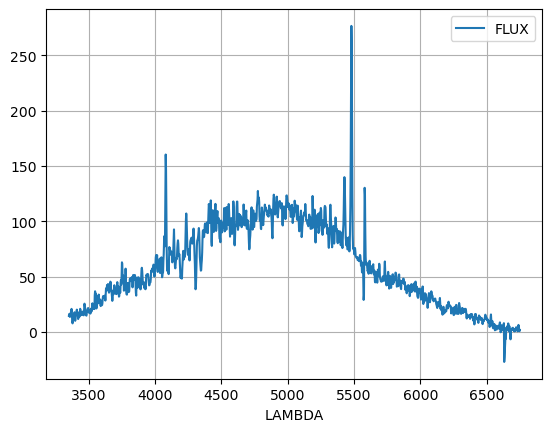

In [23]:
# Let's make a quick plot of the observed spectrum...
df_obs.plot('LAMBDA', 'FLUX')
plt.grid(True)
lcrs_objname_no_spaces = lcrs_objname.replace(' ', '_')
outputFile = """LCRSspec.%s.csv""" % (lcrs_objname_no_spaces)
outputFile = os.path.join(output_dirname, outputFile)
df_obs.to_csv(outputFile, index=False)

In [24]:
print(cz)
print(z)
print('')

# Calcium H & K lines (at 3934A and 3969A)
print(3934.*(1+z))
print(3969.*(1+z))
print('')

# G-band (4304A)
print(4304.*(1+z))
print('')

# Magnesium line (5175A) 
print(5175.*(1+z))
print('')

# Sodium line (5894A)
print(5894.*(1+z))
print()

28354.0
0.09457876355248404

4306.0728558154715
4344.383112539809

4711.066998329891

5664.445101384104

6451.44723237834



In [25]:
# Let's rebin and re-normalize both the observed spectrum and the AGN spectrum 
#  for plotting them both on the same figure...

lambda_bin = 2.5

# First the observed spectrum...
lambda_lo = df_obs.LAMBDA.min()
lambda_hi = df_obs.LAMBDA.max()
flux_max = df_obs.FLUX.max()

wavelength_array = np.arange(lambda_lo, lambda_hi, lambda_bin)

spec_flux_obs = interpolate.interp1d(df_obs.LAMBDA, df_obs.FLUX,bounds_error=False, fill_value=0.,kind='linear')
spec_flux_obs_array = spec_flux_obs(wavelength_array)

df_obs_new = pd.DataFrame({'LAMBDA':wavelength_array, 'FLUX':spec_flux_obs_array})

#norm = df_obs_new['FLUX'].median()
norm = df_obs_new['FLUX'].max()
df_obs_new['normFLUX'] = df_obs_new['FLUX']/norm


## Next the AGN template spectrum...
#spec_flux_agn = interpolate.interp1d(df_agn.WAVELENGTH, df_agn.FLUX,bounds_error=False, fill_value=0.,kind='linear')
#spec_flux_agn_array = spec_flux_agn(wavelength_array)
#
#df_agn_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Flam':spec_flux_agn_array})
#
##norm = df_agn_new['Flam'].median()
#norm = df_agn_new['Flam'].max()
#df_agn_new['normFlam'] = df_agn_new['Flam']/norm

In [26]:
# Take a look at the new spectrum dataframe for the observed object...
df_obs_new.head(10)

,LAMBDA,FLUX,normFLUX
0,3350.0,14.645643,0.052955
1,3352.5,16.281206,0.058869
2,3355.0,14.644223,0.052950
3,3357.5,13.552913,0.049004
4,3360.0,15.137865,0.054735
5,3362.5,16.927071,0.061204
6,3365.0,17.672749,0.063900
7,3367.5,19.023161,0.068783
8,3370.0,20.858038,0.075417
9,3372.5,17.943079,0.064877


## Plot

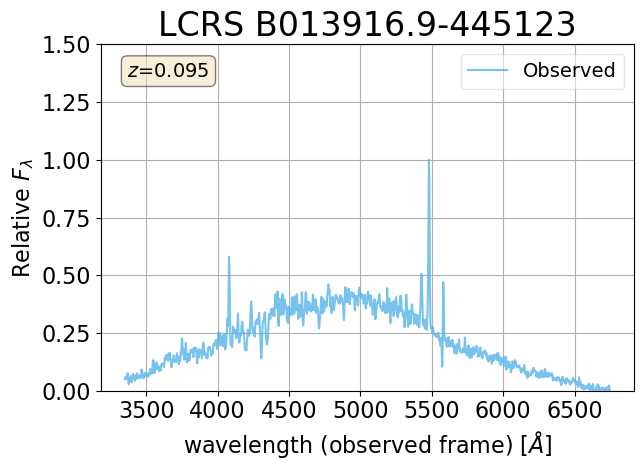

In [28]:
ax = df_obs_new.plot('LAMBDA', 'normFLUX', c='#56b4e9', alpha=0.8, label='Observed', fontsize=18)

plt.ylim([0.00, 1.5])

title = """%s""" % (lcrs_objname)
plt.title(title, fontsize=24)

ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
ax.set_ylabel('Relative $F_{\lambda}$',fontsize=16)

ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
textstr = """$z$=%.3f""" % (z)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.grid(True)

lcrs_objname_no_spaces = lcrs_objname.replace(' ', '_')
outputFile = """AGNfit.%s.png""" % (lcrs_objname_no_spaces)
outputFile = os.path.join(output_dirname, outputFile)
    
plt.tight_layout()
#plt.savefig(outputFile)
